In [93]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np

In [94]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [95]:
train_dir = "./data"
IMG_HEIGHT, IMG_WIDTH = 224, 224
batch_size = 32

training_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  labels='inferred',  
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  labels='inferred',  
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

class_names = training_data.class_names

Found 5917 files belonging to 2 classes.
Using 4734 files for training.
Found 5917 files belonging to 2 classes.
Using 1183 files for validation.


In [96]:
AUTOTUNE = tf.data.AUTOTUNE

training_data = training_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)


In [97]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    tf.keras.layers.Convolution2D(filters=16, kernel_size=(5,5)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Convolution2D(filters=32, kernel_size=(5,5)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(filters=64, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Convolution2D(filters=128, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Convolution2D(filters=256, kernel_size=(3,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    tf.keras.layers.Flatten(),
            
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 53, 53, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 25, 25, 64)      

In [98]:
"""
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(2, 'softmax')
])

base_model.trainable = False
model.summary()
"""

"\nbase_model = tf.keras.applications.resnet_v2.ResNet50V2(\n        include_top=False,\n        pooling='max',\n        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),\n        weights='imagenet')\n\nmodel = tf.keras.Sequential([\n    base_model,\n    tf.keras.layers.Dense(512, 'relu'),\n    tf.keras.layers.Dense(256, 'relu'),\n    tf.keras.layers.Dense(2, 'softmax')\n])\n\nbase_model.trainable = False\nmodel.summary()\n"

In [99]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [100]:
data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
])

In [101]:
model = tf.keras.Sequential([
  data_preprocessing,
  data_augmentation,
  #tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  #tf.keras.layers.MaxPooling2D(),
  model
])

In [102]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [103]:
epochs = 30
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/30


148/148 [==============================] - 10s 37ms/step - loss: 0.5914 - accuracy: 0.7203 - val_loss: 0.5046 - val_accuracy: 0.7642
Epoch 2/30
148/148 [==============================] - 5s 34ms/step - loss: 0.4445 - accuracy: 0.8103 - val_loss: 0.4937 - val_accuracy: 0.7566
Epoch 3/30
148/148 [==============================] - 5s 34ms/step - loss: 0.4001 - accuracy: 0.8283 - val_loss: 0.4456 - val_accuracy: 0.7997
Epoch 4/30
148/148 [==============================] - 5s 34ms/step - loss: 0.3839 - accuracy: 0.8395 - val_loss: 0.3838 - val_accuracy: 0.8411
Epoch 5/30
148/148 [==============================] - 5s 34ms/step - loss: 0.3656 - accuracy: 0.8460 - val_loss: 0.3629 - val_accuracy: 0.8529
Epoch 6/30
148/148 [==============================] - 5s 34ms/step - loss: 0.3408 - accuracy: 0.8574 - val_loss: 0.2864 - val_accuracy: 0.8943
Epoch 7/30
148/148 [==============================] - 5s 34ms/step - loss: 0.3182 - accuracy: 0.8690 - val_loss: 0.4263 - val_accuracy: 0.8462
Epoch 8/3

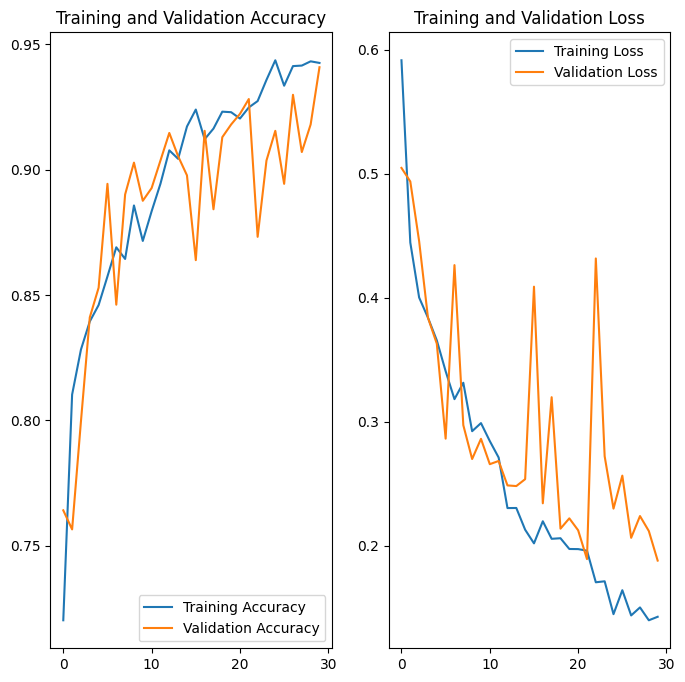

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [105]:
def predict_image(name, url):
    path = tf.keras.utils.get_file(name, origin=url)

    img = tf.keras.utils.load_img(
        path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("{} most likely belongs to {} with a {:.2f} percent confidence."
          .format(name, class_names[np.argmax(score)], 100 * np.max(score)))

In [106]:
predict_image("Red_Sunflower", "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg")

1/1 [==============================] - 0s 59ms/step
Red_Sunflower most likely belongs to muffin with a 61.06 percent confidence.


In [107]:
predict_image("Chihuahua", "https://www.purina.at/sites/default/files/styles/ttt_image_510/public/2021-02/BREED%20Hero%20Mobile_0140_chihuahua_smooth.jpg")

1/1 [==============================] - 0s 15ms/step
Chihuahua most likely belongs to chihuahua with a 73.10 percent confidence.


In [108]:
predict_image("Chocolate_Muffin", "https://img.chefkoch-cdn.de/rezepte/1692201277528566/bilder/1502355/crop-960x540/die-schnellsten-und-besten-muffins-ueberhaupt.jpg")

1/1 [==============================] - 0s 13ms/step
Chocolate_Muffin most likely belongs to muffin with a 72.52 percent confidence.


In [109]:
predict_image("Blueberry_Muffin", "https://upload.wikimedia.org/wikipedia/commons/8/8a/Muffin_NIH.jpg")

1/1 [==============================] - 0s 12ms/step
Blueberry_Muffin most likely belongs to muffin with a 70.09 percent confidence.
